In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [2]:
# TODO - move functions to module, complete docstrings
def plot_wordcloud(text):
    """Plot a wordcloud - adapted from 
    https://github.com/amueller/word_cloud/blob/master/examples/simple.py
    
    Args:
        text (str): 
            preprocessed_names or preprocessed_descriptions combined
            into a single string
        
    Returns:
        None
    """
    
    # width and height appear to affect how sharp the words are
    wordcloud = WordCloud(
        width=2400, 
        height=1200,
        collocations=False # exclude bigrams
    ).generate(text)
    
    plt.figure(figsize=(20, 10)) # adjust overall size of wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
def get_word_counts(documents, max_words=10):
    # can add ngram_range parameter to get bigrams 
    vectorizer = CountVectorizer(lowercase=False, max_features=max_words)
    
    # number of documents (row) by number of words (column)
    X = vectorizer.fit_transform(documents)
    words = vectorizer.get_feature_names()
    document_term_df = pd.DataFrame(X.toarray(), columns=words)
    word_counts = document_term_df.sum(axis=0).reset_index()
    word_counts.rename(columns={'index': 'word', 0: 'count'}, inplace=True)
    return word_counts   

def sort_word_counts(word_counts):
    sorted_word_counts = word_counts.sort_values(
        by=['count'],
        ascending=False
    )
    sorted_word_counts.reset_index(drop=True, inplace=True)
    return sorted_word_counts

def plot_word_counts(word_counts, label):
    num_words = word_counts.shape[0]
    word_count_plot = sns.barplot(data=word_counts, x='word', y='count')
    word_count_plot.set(
        title=f'Top {num_words} Words in Wikidata {label}', 
        xlabel='Word', 
        ylabel='Count'
    )
    xlabels = word_count_plot.get_xticklabels()
    word_count_plot.set_xticklabels(xlabels, rotation=30, ha='right')
    plt.show()

In [3]:
osm_data = pd.read_json('data/preprocessed_osm_data.json.gz')
wikidata = pd.read_json('data/preprocessed_wikidata.json')

In [4]:
wikidata.head(5)

,qid,preprocessed_names,preprocessed_description
0,Q37158,starbucks starbucks corporation starbucks coff...,american multinational coffee company
1,Q154950,royal dutch shell rds shell royal dutch shell plc,anglo dutch oil company
2,Q1208279,petro canada,company
3,Q867662,esso exxcon,oil gas company
4,Q175106,tim hortons tim hortons inc,multinational quick service restaurant chain


In [ ]:
# TODO - discuss chain restaurants / franchises with descriptions that do not contain the words
# 'chain' or 'restaurant', how 'corporation' in names may not be good indicator

In [5]:
names = wikidata['preprocessed_names']
descriptions = wikidata['preprocessed_description']

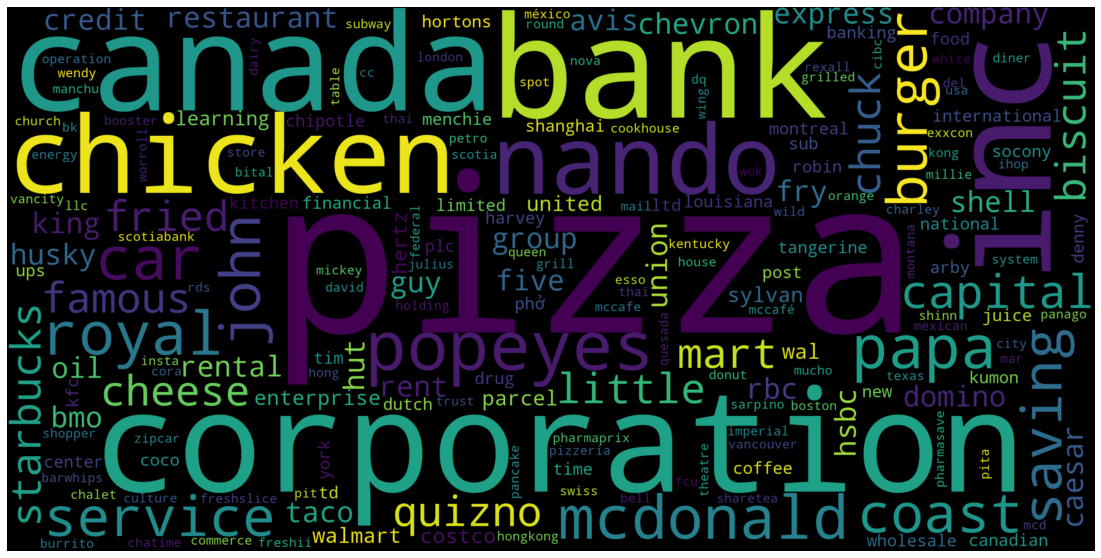

In [6]:
name_text = ' '.join(names)
plot_wordcloud(name_text)

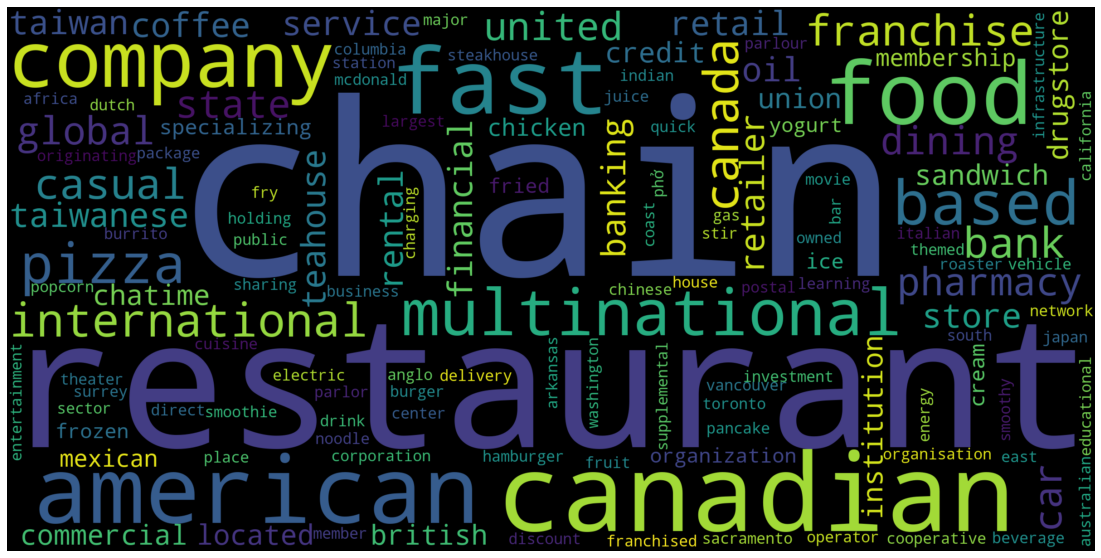

In [7]:
description_text = ' '.join(descriptions)
plot_wordcloud(description_text)

In [8]:
name_word_counts = get_word_counts(names)
name_word_counts = sort_word_counts(name_word_counts)

In [9]:
description_word_counts = get_word_counts(descriptions)
description_word_counts = sort_word_counts(description_word_counts)

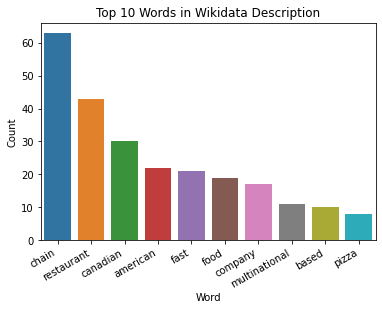

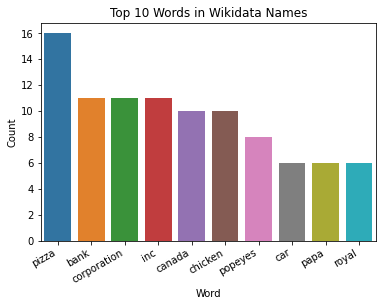

In [10]:
plot_word_counts(description_word_counts, 'Description')
plot_word_counts(name_word_counts, 'Names')